In [ ]:
#default_exp interpret.gradcam

# GradCam

> Produce heatmaps to interpret your models

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai2.vision.all import *

In [ ]:
!tree /home/synopsis/Desktop/shot-lighting-cast/ -L 2

/home/synopsis/Desktop/shot-lighting-cast/
├── models
│   ├── 120-epochs-overfit.pth
│   ├── BEST-MODEl.pth
│   ├── bestmodel-38-epochs.pth
│   ├── bestmodel.pth
│   └── tmp.pth
└── train
    ├── shot_lighting_cast_hard
    └── shot_lighting_cast_soft

4 directories, 5 files


In [ ]:
#hide
class ApplyPILFilter(RandTransform): pass
path_model = '../../CinemaNet-Training/nbs/models/fastai2-110-epoch-model.pkl'

learn = load_learner(path_model);

In [ ]:
#hide
torch.cuda.set_device(1)
torch.cuda.get_device_name()

'GeForce GTX TITAN X'

<h3> Steps for plotting GradCAM </h3>

<br>

1. Create your `Learner`'s `test_dl` w.r.t. one image and label
2. Compute activations (forward pass) and gradients (backward pass)
3. Compute gradcam-map (7x7 in this case)
    1. Take mean of gradients across feature maps: `(1280, 7, 7) --> (1280, 1, 1)`
    2. Multiply mean * activation: `(1280,1,1) * (1280,7,7) --> (1280,7,7)`
    3. Sum of (B): `(1280,7,7) --> (7,7)`
4. Plot gradcam-map over the image

In [ ]:
#export
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, inp, out):  self.stored = out.detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

class HookBwd():
    def __init__(self,m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, model, grad_in, grad_out): self.stored = grad_out[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

#### 1. Create your `Learner`'s `test_dl` w.r.t. one image and label

In [ ]:
path_imgs = '/home/synopsis/Desktop/shot-lighting-cast/train/shot_lighting_cast_soft/'
f = get_image_files(path_imgs)[120]

img = PILImage.create(f)
x   = first(learn.dls.test_dl([f]))
x   = x[0] # get image from tuple of len == 1

In [ ]:
#export
def create_test_img(learn, f, return_img=True):
    img = PILImage.create(f)
    x = first(learn.dls.test_dl([f]))
    x = x[0]
    if return_img: return img,x
    return x

In [ ]:
img,x = create_test_img(learn, f)
label = 'shot_lighting_cast_hard'

#### 2. Compute activations (forward pass) and gradients (backward pass)

In [ ]:
#export
def compute_gcam_items(learn, x, label) -> Tuple(torch.Tensor):
    'Compute gradient and activations of `model` for `x` with respect to `label`'
    
    label_idx = learn.dls.vocab.o2i[label]
    
    with HookBwd(learn.model[0]) as hook_g:
        with Hook(learn.model[0]) as hook:
            preds       = learn.model.eval()(x)
            activations = hook.stored
        preds[0, label_idx].backward()
        gradients = hook_g.stored

    preds = getattr(learn.loss_func, 'activation', noop)(preds)
    
    # remove leading batch_size axis
    gradients   = gradients  [0]
    activations = activations[0]
    
    return gradients,activations,preds.detach().numpy().flatten()

In [ ]:
gradients, activations, preds = compute_gcam_items(learn,x,label)

#### 3. Compute gradcam-map

In [ ]:
#export
def compute_gcam_map(gradients, activations):
    '(mean(gradients) * activations).sum() to return tiny grad-cam map'
    # Mean over the feature maps. If you don't use `keepdim`, it returns
    # a value of shape (1280) which isn't amenable to `*` with the activations
    gcam_weights = gradients.mean(dim=[1,2], keepdim=True) # (1280,7,7)   --> (1280,1,1)
    gcam_map     = (gcam_weights * activations) # (1280,1,1) * (1280,7,7) --> (1280,7,7)
    gcam_map     = gcam_map.sum(0)              # (1280,7,7) --> (7,7)
    return gcam_map

In [ ]:
gcam_map = compute_gcam_map(gradients, activations)

#### 4. Plot gradcam-map over the image

In [ ]:
#export
def plt_decoded(learn, x, ctx):
    'Processed tensor --> plottable image, return `extent`'
    x_decoded = TensorImage(learn.dls.train.decode((x,))[0][0])
    extent = (0, x_decoded.shape[1], x_decoded.shape[2], 0)
    x_decoded.show(ctx=ctx)
    return extent
    
def plot_gcam(img:PILImage, x:tensor, gcam_map:tensor, plt_axis,
              full_size=True, alpha=0.6, learn=None,
              interpolation='bilinear', cmap='magma'):
    'Plot gradcam on `plt_axis`'
    if full_size:
        extent = (0, img.width,img.height, 0)
        show_image(img, ctx=plt_axis)
    else:
        extent = plt_decoded(learn, x, plt_axis)

    show_image(gcam_map.detach().cpu(), ctx=plt_axis,
               alpha=alpha, extent=extent,
               interpolation=interpolation, cmap=cmap)

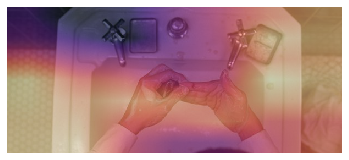

In [ ]:
fig,ax = plt.subplots()

plot_gcam(img, x, gcam_map, ax, full_size=True)

### Class interface for computing multiple Grad-CAMs for one image

In [ ]:
#export
import math
from typing import List
PathLike = Union[str,Path]

class GradCam():
    "Class interface to facilitate computing and siplaying Grad-CAM"
    def __init__(self, learn:Learner, fname:PathLike, labels:Union[str,List[str],None]):
        """
        Compute Grad-CAM maps for all `labels`.
        If `labels` is None, compute for the predicted class (more expensive)
        """
        self.learn = learn
        self.fname = fname
        self.img, self.x = create_test_img(self.learn, self.fname)
        if labels is None:
            self.labels = [self.learn.predict(fname)[0]]
        else:
            self.labels = [labels] if isinstance(labels,str) else labels
        self.compute_gcams()
    
    def compute_gcams(self):
        self.gradcams = defaultdict()
        for label in self.labels:
            gradients, activations, self.preds = compute_gcam_items(self.learn,self.x,label)
            gcam_map = compute_gcam_map(gradients, activations)
            self.gradcams[label] = gcam_map
            self.preds_dict = {
                lab:pred for pred,lab in zip(self.preds, self.learn.dls.vocab)
            }
    
    def plot(self, max_ncols=None, full_size=True, alpha=0.6,
             interpolation='bilinear', cmap='magma',
             figsize=(12,12), return_fig=False, plot_original=False):
        """
        Plot the computed Grad-CAMs.
        
        Key Arguments
        -------------
        * full_size: If True, plots the images in their original size, else
                     in the size that the `Learner` resizes them to
        * plot_original: if True, plots the original image without any overlays
                         in addition to the heatmaps
        * max_ncols: Use this to manipulate the number of rows you'd like your
                     plot to have. Useful for classifiers with a large no. of
                     outputs. Enter `None` to plot everything in one row.
        """
        label_idx = 0
        total = len(self.labels)+1 if plot_original else len(self.labels)
        
        if max_ncols is None:
            max_ncols=len(self.labels)+1 if plot_original else len(self.labels)
        
        if total > max_ncols:
            nrows  = math.ceil(total/max_ncols)
            fig,ax = plt.subplots(nrows=nrows, ncols=max_ncols, figsize=figsize)
            plt.axis('off')
            
            for i in range(nrows):
                for j in range(max_ncols):
                    if plot_original:
                        if i==0 and j==0:
                            if full_size:
                                show_image(self.img, ctx=ax[0,0])
                            else:
                                x = TensorImage(learn.dls.train.decode((self.x,))[0][0])
                                x.show(ctx=ax[0,0])
                            ax[0][0].set_title('original')
                            continue
                    plot_gcam(img=self.img, x=self.x, full_size=full_size,
                              gcam_map=self.gradcams[self.labels[label_idx]],
                              plt_axis=ax[i,j], alpha=alpha, learn=self.learn,
                              interpolation=interpolation, cmap=cmap)
                    title = self.labels[label_idx]
                    ax[i][j].set_title(f'{title}, {self.preds_dict[title] * 100:.02f}%')
                    label_idx += 1
                    if label_idx >= len(self.labels): break
        else:
            fig,ax = plt.subplots(nrows=1, ncols=max_ncols, figsize=figsize)
            plt.axis('off')
            
            for i in range(len(ax)):
                if plot_original:
                    if i==0 and full_size:
                        show_image(self.img, ctx=ax[0])
                        ax[0].set_title('original')
                        continue
                    elif i==0 and not full_size:
                        _ = plt_decoded(self.learn, self.x, ctx=ax[0])
                        ax[0].set_title('original')
                        continue
                plot_gcam(img=self.img, x=self.x, full_size=full_size,
                          gcam_map=self.gradcams[self.labels[label_idx]],
                          plt_axis=ax[i], alpha=alpha, learn=self.learn,
                          interpolation=interpolation, cmap=cmap) 
                title = self.labels[label_idx]
                ax[i].set_title(f'{title}, {self.preds_dict[title] * 100:.02f}%')
                label_idx += 1

In [ ]:
f = get_image_files(path_imgs)[100]

In [ ]:
#hide
from nbdev.showdoc import show_doc
show_doc(GradCam.__init__)

<h4 id="GradCam.__init__" class="doc_header"><code>GradCam.__init__</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>GradCam.__init__</code>(**`learn`**:`Learner`, **`fname`**:`Union`\[`str`, `Path`\], **`labels`**:`Union`\[`str`, `List`\[`str`\], `NoneType`\])

```
Compute Grad-CAM maps for all `labels`.
If `labels` is None, compute for the predicted class (more expensive)
```

A `GradCAM` object can be initialised, passing in a `Learner` and as many `labels` as you'd like to compute the GradCAM heatmaps for. <br>
The GradCAM tensors can be accessed via `GradCAM.gradcams` which is a dictionary whose keys are the `labels` you pass in

In [ ]:
gcam = GradCam(learn, f, labels=['shot_lighting_cast_hard', 'shot_lighting_cast_soft'])

In [ ]:
{k:v.shape for k,v in gcam.gradcams.items()}

{'shot_lighting_cast_hard': torch.Size([7, 7]),
 'shot_lighting_cast_soft': torch.Size([7, 7])}

In [ ]:
show_doc(GradCam.plot)

<h4 id="GradCam.plot" class="doc_header"><code>GradCam.plot</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>GradCam.plot</code>(**`max_ncols`**=*`None`*, **`full_size`**=*`True`*, **`alpha`**=*`0.6`*, **`interpolation`**=*`'bilinear'`*, **`cmap`**=*`'magma'`*, **`figsize`**=*`(12, 12)`*, **`return_fig`**=*`False`*, **`plot_original`**=*`False`*)

```
Plot the computed Grad-CAMs.

Key Arguments
-------------
* full_size: If True, plots the images in their original size, else
             in the size that the `Learner` resizes them to
* plot_original: if True, plots the original image without any overlays
                 in addition to the heatmaps
* max_ncols: Use this to manipulate the number of rows you'd like your
             plot to have. Useful for classifiers with a large no. of
             outputs. Enter `None` to plot everything in one row.
```

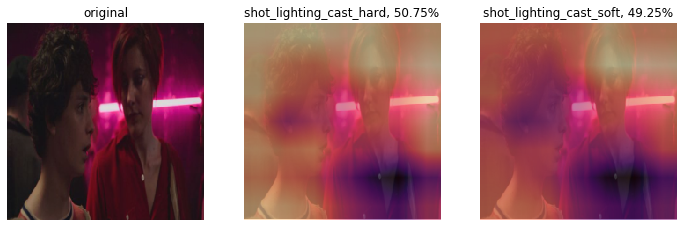

In [ ]:
gcam.plot(full_size=False, plot_original=True)

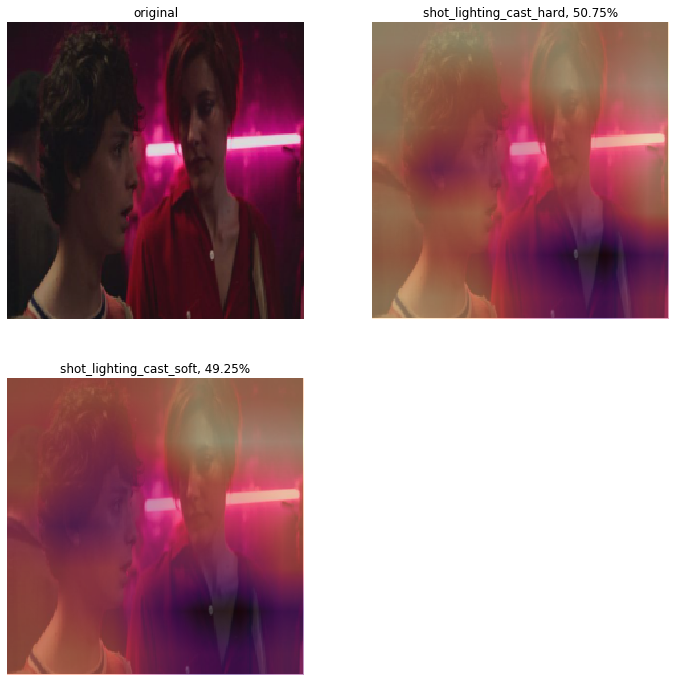

In [ ]:
gcam.plot(max_ncols=2, full_size=False, plot_original=True, alpha=0.5)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_interpret_classification-interpretation.ipynb.
Converted 02_interpret_compare-models.ipynb.
Converted 03_interpret_gradcam.ipynb.
Converted 04_inference_export-to-other-frameworks.ipynb.
Converted 05_augment_PIL-img_filters.ipynb.
Converted index.ipynb.
